### To test/confirm if randstainna.yaml works, build a DataLoader with the new_train_df and then save some images for comparison to see if normalization+augmentation worked:

In [1]:
import os
from randstainna import RandStainNA
import cv2
from torchvision import transforms
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch
import random

In [2]:
# sets the seed of the entire notebook so results are the same every time we run for reproducibility. no randomness, everything is controlled.
def set_seed(seed = 42):
    np.random.seed(seed) #numpy specific random
    random.seed(seed) # python specific random (also for albumentation augmentations)
    torch.manual_seed(seed) # torch specific random
    torch.cuda.manual_seed(seed) # cuda specific random
    # when running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # when deterministic = true, benchmark = False, otherwise might not be deterministic
    os.environ['PYTHONHASHSEED'] = str(seed)  # set a fixed value for the hash seed, for hases like dictionary

set_seed(seed=42)

In [3]:
new_train_src = r"C:\Users\Kevin\Desktop\hubmap\new_train.xlsx"
new_train_df = pd.read_excel(new_train_src)
train_img_src = r"C:\Users\Kevin\Desktop\hubmap\train"

In [4]:
new_train_df

,Unnamed: 0,id,type,coordinates,mask,rle
0,0,0006ff2aa7cd,glomerulus,"[[[167, 249], [166, 249], [165, 249], [164, 24...",[[0 1 1 ... 0 0 0]\n [1 1 1 ... 0 0 0]\n [1 1 ...,['2 105 513 107 1025 111 1537 113 2049 114 256...
1,1,0006ff2aa7cd,blood_vessel,"[[[283, 109], [282, 109], [281, 109], [280, 10...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['139350 10 139860 17 140370 22 140880 27 1413...
2,2,0006ff2aa7cd,blood_vessel,"[[[104, 292], [103, 292], [102, 292], [101, 29...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['37108 4 37618 8 38129 11 38640 14 39152 15 3...
3,3,0006ff2aa7cd,blood_vessel,"[[[505, 442], [504, 442], [503, 442], [502, 44...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['250783 11 251292 20 251801 26 252311 30 2528...
4,4,0006ff2aa7cd,blood_vessel,"[[[375, 477], [374, 477], [373, 477], [372, 47...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['167352 5 167863 7 168374 10 168886 11 169398...
...,...,...,...,...,...,...
17513,17513,ffd3d193c71e,blood_vessel,"[[[184, 308], [183, 308], [182, 308], [181, 30...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['88875 8 89385 11 89896 13 90407 15 90918 16 ...
17514,17514,ffd3d193c71e,blood_vessel,"[[[42, 92], [41, 92], [40, 92], [39, 92], [38,...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['14393 12 14904 20 15415 23 15925 28 16434 40...
17515,17515,ffd3d193c71e,blood_vessel,"[[[287, 480], [286, 480], [285, 480], [284, 48...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['140243 6 140750 13 141261 15 141772 17 14228...
17516,17516,ffd3d193c71e,blood_vessel,"[[[493, 388], [492, 388], [491, 388], [490, 38...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['244001 5 244512 7 244603 6 245023 9 245112 1...


In [5]:
tmp_df = new_train_df.copy()
id_list = new_train_df['id'].tolist()
tmp_df["imagepaths"] = [os.path.join(train_img_src,x + ".tif") for x in id_list]
tmp_df

,Unnamed: 0,id,type,coordinates,mask,rle,imagepaths
0,0,0006ff2aa7cd,glomerulus,"[[[167, 249], [166, 249], [165, 249], [164, 24...",[[0 1 1 ... 0 0 0]\n [1 1 1 ... 0 0 0]\n [1 1 ...,['2 105 513 107 1025 111 1537 113 2049 114 256...,C:\Users\Kevin\Desktop\hubmap\train\0006ff2aa7...
1,1,0006ff2aa7cd,blood_vessel,"[[[283, 109], [282, 109], [281, 109], [280, 10...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['139350 10 139860 17 140370 22 140880 27 1413...,C:\Users\Kevin\Desktop\hubmap\train\0006ff2aa7...
2,2,0006ff2aa7cd,blood_vessel,"[[[104, 292], [103, 292], [102, 292], [101, 29...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['37108 4 37618 8 38129 11 38640 14 39152 15 3...,C:\Users\Kevin\Desktop\hubmap\train\0006ff2aa7...
3,3,0006ff2aa7cd,blood_vessel,"[[[505, 442], [504, 442], [503, 442], [502, 44...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['250783 11 251292 20 251801 26 252311 30 2528...,C:\Users\Kevin\Desktop\hubmap\train\0006ff2aa7...
4,4,0006ff2aa7cd,blood_vessel,"[[[375, 477], [374, 477], [373, 477], [372, 47...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['167352 5 167863 7 168374 10 168886 11 169398...,C:\Users\Kevin\Desktop\hubmap\train\0006ff2aa7...
...,...,...,...,...,...,...,...
17513,17513,ffd3d193c71e,blood_vessel,"[[[184, 308], [183, 308], [182, 308], [181, 30...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['88875 8 89385 11 89896 13 90407 15 90918 16 ...,C:\Users\Kevin\Desktop\hubmap\train\ffd3d193c7...
17514,17514,ffd3d193c71e,blood_vessel,"[[[42, 92], [41, 92], [40, 92], [39, 92], [38,...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['14393 12 14904 20 15415 23 15925 28 16434 40...,C:\Users\Kevin\Desktop\hubmap\train\ffd3d193c7...
17515,17515,ffd3d193c71e,blood_vessel,"[[[287, 480], [286, 480], [285, 480], [284, 48...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['140243 6 140750 13 141261 15 141772 17 14228...,C:\Users\Kevin\Desktop\hubmap\train\ffd3d193c7...
17516,17516,ffd3d193c71e,blood_vessel,"[[[493, 388], [492, 388], [491, 388], [490, 38...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['244001 5 244512 7 244603 6 245023 9 245112 1...,C:\Users\Kevin\Desktop\hubmap\train\ffd3d193c7...


In [6]:
#### calling the randstainna transforms
transforms_list = transforms.Compose([
    RandStainNA(
        yaml_file="randstainna.yaml",
        std_hyper=-0.3,
        probability=1.0,
        distribution="normal",
        is_train=True,
    )
])
transforms_list

Compose(
    RandStainNA(methods=Reinhard, colorspace=LAB, mean={'avg': [137.193, 162.05, 108.921], 'std': [16.589, 6.501, 7.309]}, std={'avg': [38.404, 11.281, 7.362], 'std': [6.284, 2.19, 1.948]}, std_adjust=-0.3, distribution=normal, p=1.0)
)

In [7]:
class RandstainDataSet(Dataset):
    def __init__(self,df,transforms=True):
        self.df = df
        self.imagepaths = df["imagepaths"].tolist()
        self.transforms = transforms
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        image_path = self.imagepaths[idx]
        image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        if transforms:
            image = self.transforms(image)
        image = torch.from_numpy(image)
        image = torch.permute(image,(2,1,0))
        return image, image_path

In [8]:
rstain_dataset = RandstainDataSet(df = tmp_df,transforms=transforms_list)
train_dataloader = DataLoader(dataset = rstain_dataset,
        batch_size = 5, # pin_memory= true allows faster data transport from cpu to gpu
        num_workers = 0, pin_memory = True, shuffle = True)
image, imagepath= next(iter(train_dataloader))
print("Images have a tensor size of {} and image_path has length {}".
      format(image.size(),len(imagepath)))
# we can see it works!

Images have a tensor size of torch.Size([5, 3, 512, 512]) and image_path has length 5


In [9]:
#Now visualize and save example images:
def visualize_transformed_images(num_images=5, save_path=None, save = False):
    rstain_dataset = RandstainDataSet(df = tmp_df,transforms=transforms_list)
    train_dataloader = DataLoader(dataset = rstain_dataset,
        batch_size = num_images, # pin_memory= true allows faster data transport from cpu to gpu
        num_workers = 0, pin_memory = True, shuffle = True)
    images, imagepaths = next(iter(train_dataloader))
    print("Images have a tensor size of {} and image_path has length {}".
      format(images.size(),len(imagepaths)))
    original_images = []
    for i in range(num_images):
        tmp_img = cv2.imread(imagepaths[i],cv2.COLOR_BGR2RGB)
        tmp_img_ra = np.array(tmp_img)
        tmp_img_tensor = torch.from_numpy(tmp_img_ra)
        tmp_img_tensor = torch.permute(tmp_img_tensor,(2,1,0))
        original_images.append(tmp_img_tensor)
    transformed_images = []
    for j in range(num_images):
        transformed_images.append(images[j])
    original_images_tensor = torch.stack(original_images,dim=0)
    transformed_images_tensor = torch.stack(transformed_images,dim=0)
    grid_original = vutils.make_grid(original_images_tensor,nrow = 5,padding=0)
    grid_transformed = vutils.make_grid(transformed_images_tensor, nrow = 5,padding=0)

    grid_original = grid_original.permute(1,2,0)
    grid_transformed = grid_transformed.permute(1,2,0)
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    axes[0].imshow(grid_original)
    axes[0].set_title("Original Images")
    axes[0].axis("off")
    axes[1].imshow(grid_transformed)
    axes[1].set_title("Transformed Images")
    axes[1].axis("off")

    if save_path is not None and save:
        plt.savefig(save_path)
        plt.close()
        print("Images saved successfully.")

    plt.show()


Images have a tensor size of torch.Size([5, 3, 512, 512]) and image_path has length 5


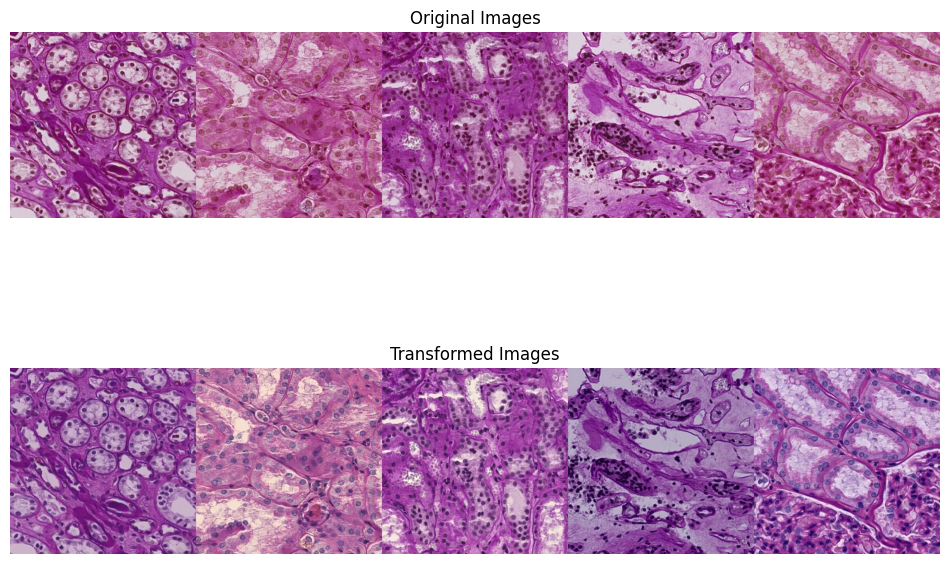

In [10]:
visualize_transformed_images(num_images = 5, save_path = r"C:\Users\Kevin\Desktop\hubmap\randstain_only.png", save = False)

### So according to Lunit's article (https://openaccess.thecvf.com/content/CVPR2023/papers/Kang_Benchmarking_Self-Supervised_Learning_on_Diverse_Pathology_Datasets_CVPR_2023_paper.pdf), on top of the RandStainNA for normalization & augmentation, which is done at the last step, the order of image augmentation/preprocessing should be in this order:
1. Random vertical and horizontal flips
2. Weak Color Jitter
3. Grayscale
4. RandStainNA

Showing all of these steps as below:

In [11]:
#### calling all of the transforms and then the randstainna transforms at last:
transforms_list_final = transforms.Compose([
    transforms.ToPILImage(mode='RGB'), # for colorjitter
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness = 0.1, contrast = 0.1, saturation = 0.1, hue = 0.05),
    transforms.RandomGrayscale(p=0.1),
    RandStainNA(
        yaml_file="randstainna.yaml",
        std_hyper=-0.3,
        probability=1.0,
        distribution="normal",
        is_train=True,
    )
])
transforms_list_final

Compose(
    ToPILImage(mode=RGB)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.05, 0.05))
    RandomGrayscale(p=0.1)
    RandStainNA(methods=Reinhard, colorspace=LAB, mean={'avg': [137.193, 162.05, 108.921], 'std': [16.589, 6.501, 7.309]}, std={'avg': [38.404, 11.281, 7.362], 'std': [6.284, 2.19, 1.948]}, std_adjust=-0.3, distribution=normal, p=1.0)
)

In [12]:
rstain_dataset_final = RandstainDataSet(df = tmp_df,transforms=transforms_list_final)
train_dataloader_final = DataLoader(dataset = rstain_dataset_final,
        batch_size = 5, # pin_memory= true allows faster data transport from cpu to gpu
        num_workers = 0, pin_memory = True, shuffle = True)
image, imagepath= next(iter(train_dataloader_final))
print("Images have a tensor size of {} and image_path has length {}".
      format(image.size(),len(imagepath)))
# we can see it works!

Images have a tensor size of torch.Size([5, 3, 512, 512]) and image_path has length 5


In [13]:
#Now visualize and save example images:
def visualize_transformed_images_v2(num_images=5, save_path=None, save = False):
    rstain_dataset = RandstainDataSet(df = tmp_df,transforms=transforms_list_final)
    train_dataloader = DataLoader(dataset = rstain_dataset,
        batch_size = num_images, # pin_memory= true allows faster data transport from cpu to gpu
        num_workers = 0, pin_memory = True, shuffle = True)
    images, imagepaths = next(iter(train_dataloader))
    print("Images have a tensor size of {} and image_path has length {}".
      format(images.size(),len(imagepaths)))
    original_images = []
    for i in range(num_images):
        tmp_img = cv2.imread(imagepaths[i],cv2.COLOR_BGR2RGB)
        tmp_img_ra = np.array(tmp_img)
        tmp_img_tensor = torch.from_numpy(tmp_img_ra)
        tmp_img_tensor = torch.permute(tmp_img_tensor,(2,1,0))
        original_images.append(tmp_img_tensor)
    transformed_images = []
    for j in range(num_images):
        transformed_images.append(images[j])
    original_images_tensor = torch.stack(original_images,dim=0)
    transformed_images_tensor = torch.stack(transformed_images,dim=0)
    grid_original = vutils.make_grid(original_images_tensor,nrow = 5,padding=0)
    grid_transformed = vutils.make_grid(transformed_images_tensor, nrow = 5,padding=0)

    grid_original = grid_original.permute(1,2,0)
    grid_transformed = grid_transformed.permute(1,2,0)
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    axes[0].imshow(grid_original)
    axes[0].set_title("Original Images")
    axes[0].axis("off")
    axes[1].imshow(grid_transformed)
    axes[1].set_title("Transformed Images")
    axes[1].axis("off")

    if save_path is not None and save:
        plt.savefig(save_path)
        plt.close()
        print("Images saved successfully.")

    plt.show()


Images have a tensor size of torch.Size([5, 3, 512, 512]) and image_path has length 5


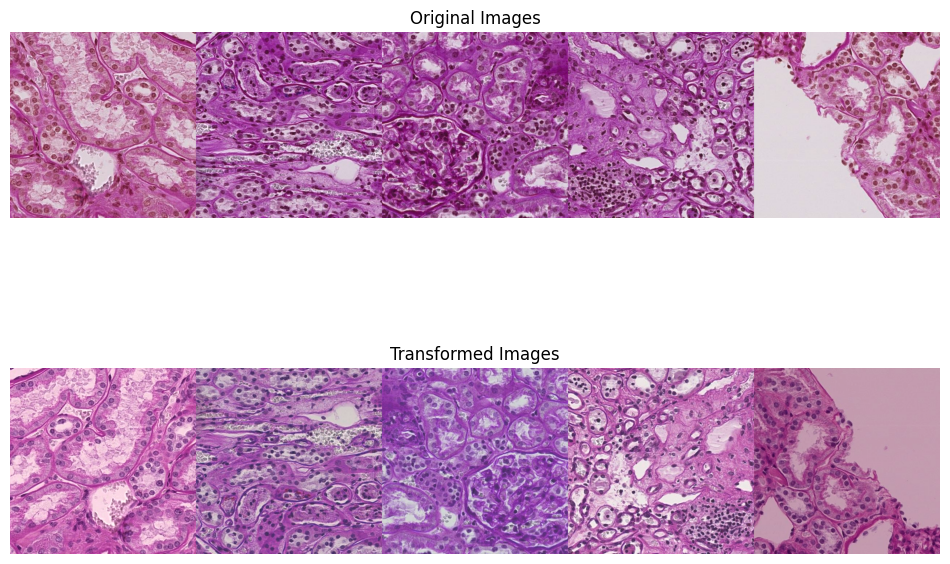

In [14]:
visualize_transformed_images_v2(num_images = 5, save_path = r"C:\Users\Kevin\Desktop\hubmap\full_augmentation.png", save = False)